# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 5std of timeseries demeaned data **good for spiky data like chlor, sal in interface** and should be applied when there is a seasonal baseline shift (duration of rolling mean?) *TODO: make subroutine and output flag to variables*
    
    
- input:
    - timeseries data
- output:
    - timeseries data, flags
    
TODO:
- linearly fill (foward or back?) no more than x number of points (likely 1) -> interp_na(limit=1)
- output to xarray modified netcdf file

***Applied to Following instruments***
- bbfl2w (chlorophyl)

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [2]:
# testfile = '../staticdata/example_data/nc_data/16bsm2a_eco_0000m.nc'
testfile = '24ckp1a_eco_0038m.nc'

So lets load a timeseries and apply filters to the entire period

In [3]:
xdf = xa.load_dataset(testfile)
xdf

<xarray.Dataset> Size: 214kB
Dimensions:             (time: 8907, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 71kB 2024-08-15T23:00:00 ... 20...
  * latitude            (latitude) float64 8B 70.84
  * longitude           (longitude) float64 8B -163.1
  * depth               (depth) float64 8B 39.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 71kB 2.421...
    turbidity           (time, depth, latitude, longitude) float64 71kB 2.468...
Attributes: (12/15)
    Latitude_DegMMddW:                      70 50.22 N
    Longitude_DegMMddN:                     163 7.56 W
    MooringID:                              24CKP-1A
    platform_deployment_date:               2024-08-15T22:55:00Z
    platform_deployment_cruise_name:        SKQ202412S
    platform_recovery_date:                 2025-08-22T01:16:53Z
    ...                                     ...
    InstrumentSerialNumber:                 4878
    InstrumentType:                         Eco-Fluorometer FLNTUSB
    date_created:                           2025-09-22T08:26:08Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [4]:
var_choice = 'chlor_fluorescence'

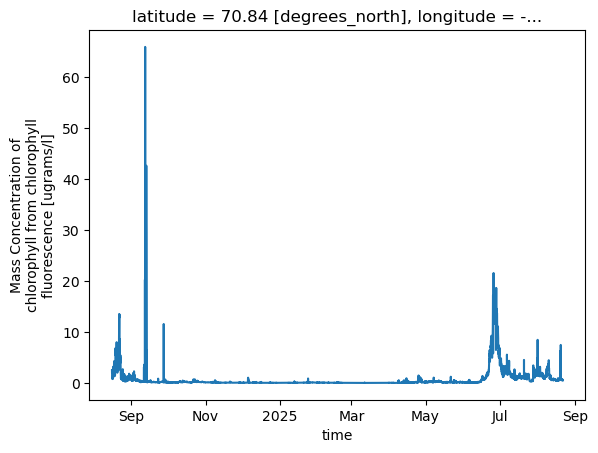

In [5]:
xdf[var_choice].plot()

In [6]:
df = xdf[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','latitude','longitude'],axis=1)
dft = df.dropna()
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft[var_choice].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

In [7]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf[var_choice])
STDcleaned = cleaning.outlier_bounds_std(xdf[var_choice])

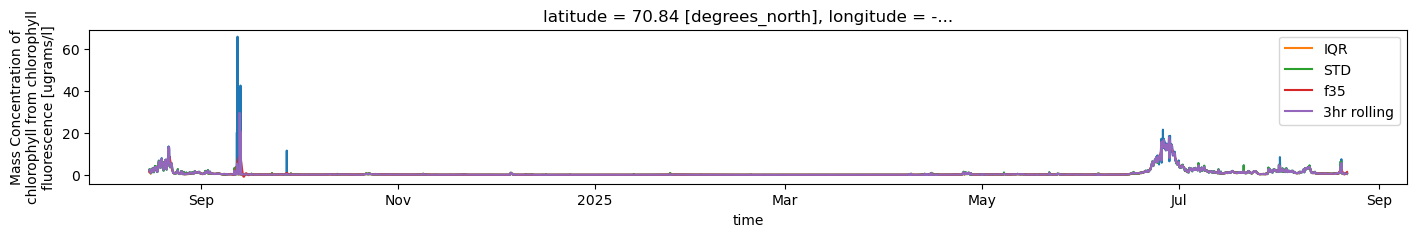

In [8]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)

ax.legend()


But perhaps a form of rolling std/iqr filter is more appropriate as it wont tend to mask relevant peaks by being a median filter

In [9]:
xdf

<xarray.Dataset> Size: 214kB
Dimensions:             (time: 8907, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 71kB 2024-08-15T23:00:00 ... 20...
  * latitude            (latitude) float64 8B 70.84
  * longitude           (longitude) float64 8B -163.1
  * depth               (depth) float64 8B 39.0
Data variables:
    chlor_fluorescence  (time, depth, latitude, longitude) float64 71kB 2.421...
    turbidity           (time, depth, latitude, longitude) float64 71kB 2.468...
Attributes: (12/15)
    Latitude_DegMMddW:                      70 50.22 N
    Longitude_DegMMddN:                     163 7.56 W
    MooringID:                              24CKP-1A
    platform_deployment_date:               2024-08-15T22:55:00Z
    platform_deployment_cruise_name:        SKQ202412S
    platform_recovery_date:                 2025-08-22T01:16:53Z
    ...                                     ...
    InstrumentSerialNumber:                 4878
    InstrumentType:                         Eco-Fluorometer FLNTUSB
    date_created:                           2025-09-22T08:26:08Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

*Finally* try to refill as many points back to the start and finish of the 

In [10]:
N = 3 #which is N*2+1 for hour window
clean = cleaning.rolling_outlier_std(xdf,var_choice,timebase=N*2+1,stddev=5,interp_fill_timebase='1h')

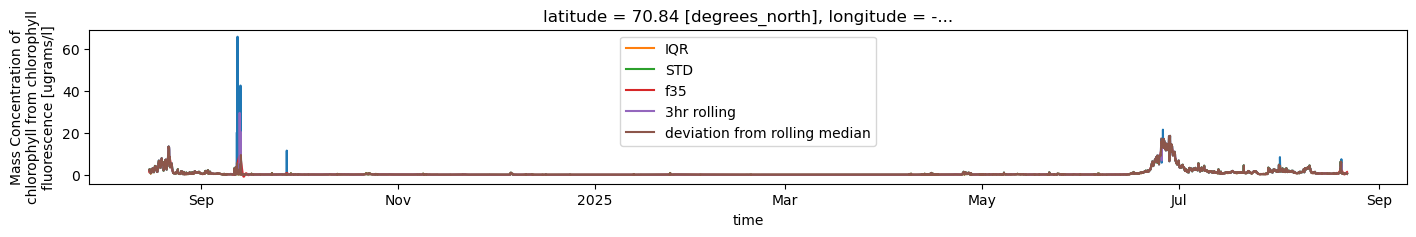

In [11]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf[var_choice].plot(ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median()[var_choice].plot(label='3hr rolling', ax=ax)
clean[var_choice].plot(label='deviation from rolling median', ax=ax)

ax.legend()


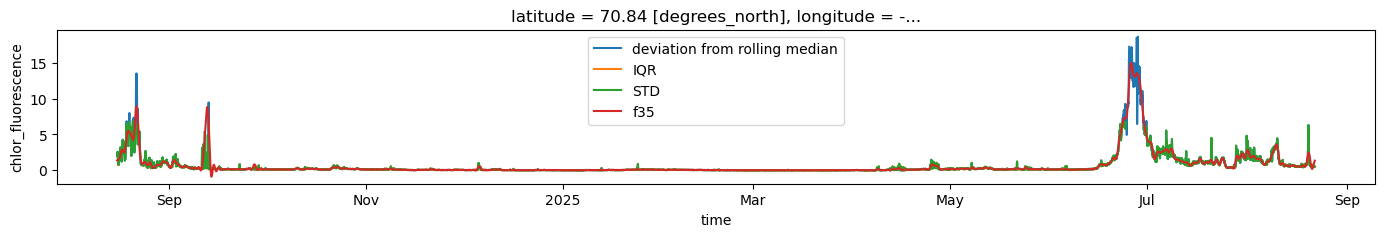

In [12]:
fig, ax = plt.subplots(figsize=(17, 2))

clean[var_choice].plot(label='deviation from rolling median', ax=ax)
((xdf[var_choice] * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf[var_choice] * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)

# ax.set_ylim([0,50])
ax.legend()


In [13]:
clean.to_dataframe().to_csv(testfile.replace('.nc','.despiked.csv'))

In [14]:
#replace original data with editied data
xdf[var_choice] = clean[var_choice]

### Update global attributes

In [15]:
xdf.attrs.update({'QC_indicator': 'ProbablyGood'})
xdf.attrs.update({'history':(xdf.history + f"\n{var_choice} filtered: "+ str(datetime.datetime.today()))})

In [16]:
xdf.attrs.update({'date_modified':str(datetime.datetime.today())})

In [17]:
xdf.to_netcdf(testfile.replace('.nc','.filtered.nc'),format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_12547/2373121271.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(testfile.replace('.nc','.filtered.nc'),format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})
